# Full Pipeline

- Enhancement
- Segmentation
- Thresholding
- Edge extraction
- Reconstruction

## 1. Imports

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

from src.enhancement import enhance_image
from src.segmentation import segment_and_extract
from src.thresholding import threshold_adaptive
from src.edge_detection import canny_edges
from src.reconstruction import (
    solve_2x2,
    solve_NxN,
    assemble_2x2,
    assemble_NxN,
)


## 2. Configuration

In [7]:
DATASET_FOLDER = "data/raw/Gravity Falls/puzzle_2x2"

# Fixed grid size (no auto-detection)
if "2x2" in DATASET_FOLDER:
    GRID_SIZE = 2
elif "4x4" in DATASET_FOLDER:
    GRID_SIZE = 4
elif "8x8" in DATASET_FOLDER:
    GRID_SIZE = 8
else:
    raise ValueError("Cannot infer grid size")

print("Grid size:", GRID_SIZE)

Grid size: 2


## 3. Helper Display Functions

In [8]:
def show(img, title="", cmap=None):
    plt.figure(figsize=(4,4))
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def show_grid(images, cols, title=""):
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(cols*3, rows*3))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if img.ndim == 2:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

## 4. Process Images In-Memory

Available files (base names):
0 0
1 1
2 10
3 100
4 101
5 102
6 103
7 104
8 105
9 106
10 107
11 108
12 109
13 11
14 12
15 13
16 14
17 15
18 16
19 17
20 18
21 19
22 2
23 20
24 21
25 22
26 23
27 24
28 25
29 26
30 27
31 28
32 29
33 3
34 30
35 31
36 32
37 33
38 34
39 35
40 36
41 37
42 38
43 39
44 4
45 40
46 41
47 42
48 43
49 44
50 45
51 46
52 47
53 48
54 49
55 5
56 50
57 51
58 52
59 53
60 54
61 55
62 56
63 57
64 58
65 59
66 6
67 60
68 61
69 62
70 63
71 64
72 65
73 66
74 67
75 68
76 69
77 7
78 70
79 71
80 72
81 73
82 74
83 75
84 76
85 77
86 78
87 79
88 8
89 80
90 81
91 82
92 83
93 84
94 85
95 86
96 87
97 88
98 89
99 9
100 90
101 91
102 92
103 93
104 94
105 95
106 96
107 97
108 98
109 99
Processing 0.jpg


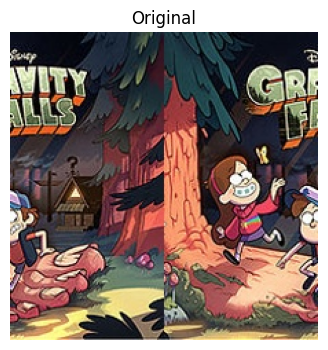

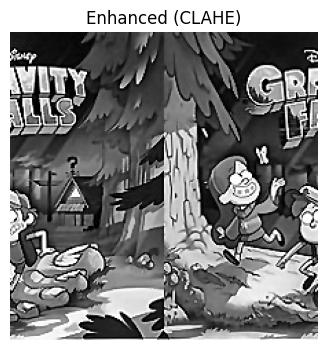

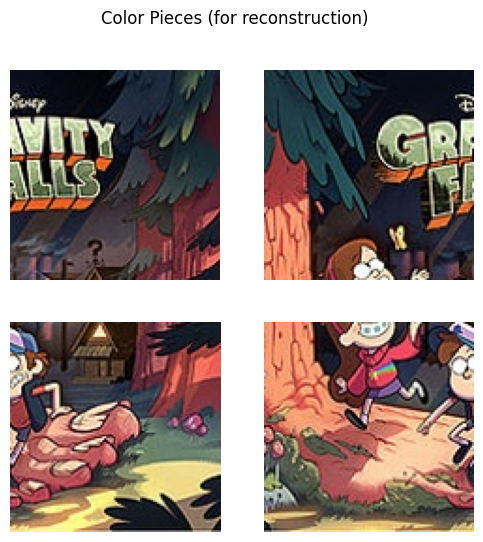

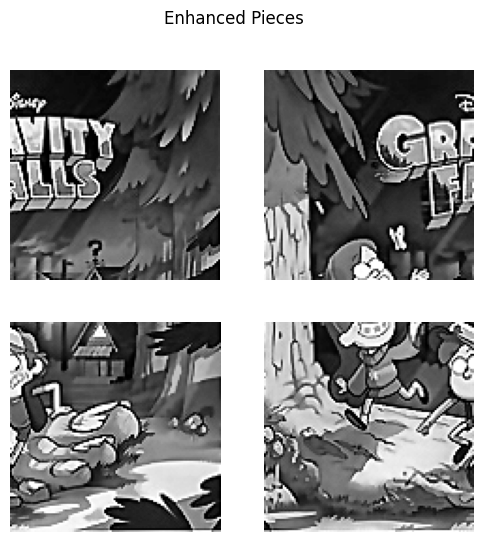

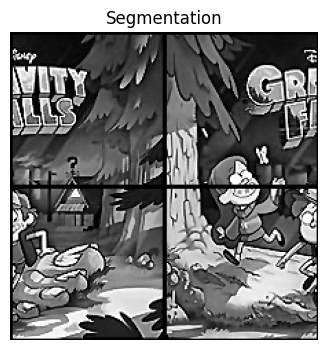

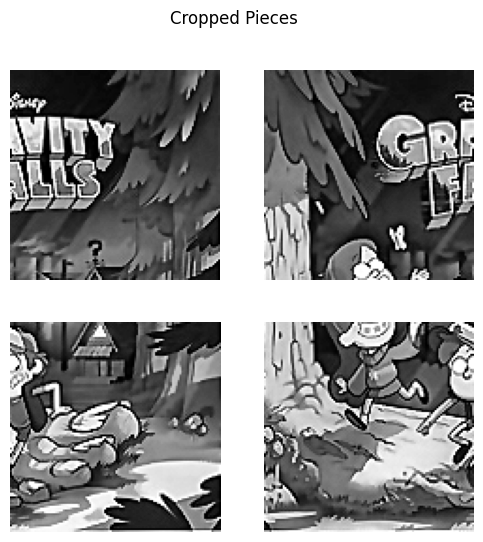

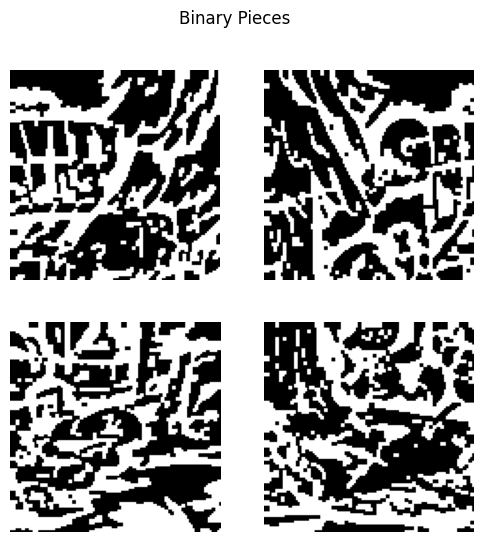

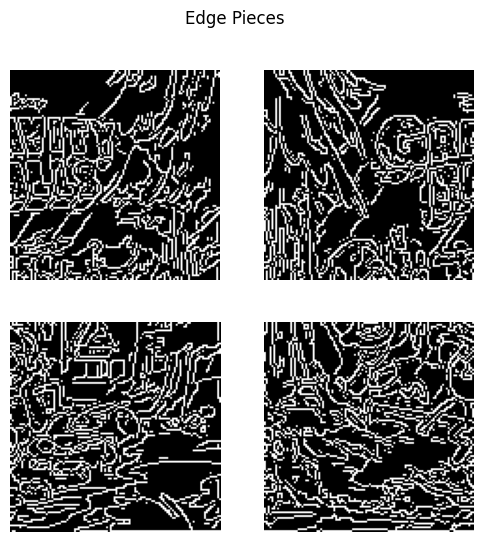

In [9]:
# List available files and select one by base filename (without extension)
files = sorted([f for f in os.listdir(DATASET_FOLDER) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
if not files:
    raise RuntimeError('No image files found in DATASET_FOLDER')

print('Available files (base names):')
for i,f in enumerate(files):
    print(i, os.path.splitext(f)[0])

SELECT_NAME = None

try:
    SELECT_NAME # type: ignore
except NameError:
    SELECT_NAME = None

if SELECT_NAME is None:
    sel = input("Enter filename (base name, without extension) to process: ")
    SELECT_NAME = sel.strip()

# Find matching file (exact base name), allow partial prefix match if exact not found
matches = [f for f in files if os.path.splitext(f)[0] == SELECT_NAME]
if not matches:
    # try prefix match
    matches = [f for f in files if os.path.splitext(f)[0].startswith(SELECT_NAME)]

if not matches:
    raise RuntimeError(f'No file matches base name: {SELECT_NAME}. Available: {[os.path.splitext(f)[0] for f in files]}')

filename = matches[0]
img_path = os.path.join(DATASET_FOLDER, filename)
original = cv2.imread(img_path)
if original is None:
    raise RuntimeError(f'Could not read image: {img_path}')

print(f"Processing {filename}")
show(original, "Original")

enhanced, enhanced_clahe = enhance_image(original)
show(enhanced_clahe, "Enhanced (CLAHE)")

# Enhanced (grayscale) pieces → diagnostics
contour_img, enhanced_pieces, _ = segment_and_extract(
    enhanced_clahe, GRID_SIZE, filename
)

# Original COLOR pieces → reconstruction
_, color_pieces, _ = segment_and_extract(
    original, GRID_SIZE, filename
)

# Display
show_grid(color_pieces, GRID_SIZE, "Color Pieces (for reconstruction)")
show_grid(enhanced_pieces, GRID_SIZE, "Enhanced Pieces")

show(contour_img, "Segmentation")
show_grid(enhanced_pieces, GRID_SIZE, "Cropped Pieces")

binary_pieces = [threshold_adaptive(p) for p in enhanced_pieces]
show_grid(binary_pieces, GRID_SIZE, "Binary Pieces")

edge_pieces = [canny_edges(p) for p in enhanced_pieces]
show_grid(edge_pieces, GRID_SIZE, "Edge Pieces")

all_puzzles = [enhanced_pieces]

## 5. Reconstruction (In-Memory)

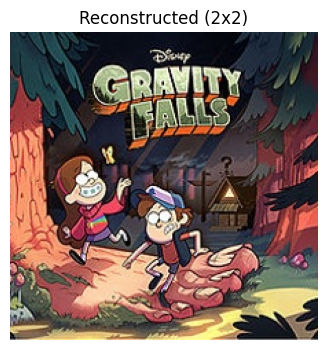

In [10]:
from src.reconstruction import slice_edges_color, solve_2x2
import numpy as np

piece_dicts = []

for p in color_pieces:  # <-- COLOR pieces
    top, right, bottom, left = slice_edges_color(p)
    piece_dicts.append({
        "top": top,
        "right": right,
        "bottom": bottom,
        "left": left,
        "img": p,
    })

sol = solve_2x2(piece_dicts)

if sol is None:
    print("No solution found")
else:
    imgs = [x["img"] for x in sol]
    h, w = imgs[0].shape[:2]

    canvas = np.zeros((2*h, 2*w, 3), np.uint8)
    canvas[:h, :w] = imgs[0]
    canvas[:h, w:] = imgs[1]
    canvas[h:, :w] = imgs[2]
    canvas[h:, w:] = imgs[3]

    show(canvas, "Reconstructed (2x2)")
